In [2]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_folder = '/content/drive/MyDrive/Dataset/data'
step_data_frames = []

# Loop through the data folder and its subfolders
for root, dirs, files in os.walk(data_folder):
    for filename in files:
        # Check if the file is a .csv file
        if filename.endswith('.csv'):
            csv_path = os.path.join(root, filename)
            step_mixed_path = os.path.join(root, filename.replace("Clipped", "") + '.stepMixed')

            # Check if the corresponding .csv.stepMixed file exists
            if os.path.exists(step_mixed_path):
                # Read the .csv file
                step_data = pd.read_csv(csv_path, usecols=[1, 2, 3, 4, 5, 6])
                step_data = step_data.dropna()  # Removes missing values

                # Reads StepIndices value - Start and End index of a step
                col_names = ['start_index', 'end_index']
                step_indices = pd.read_csv(step_mixed_path, names=col_names)

                # Removing missing values and outliers
                step_indices = step_indices.dropna()
                step_indices = step_indices.loc[(step_indices.end_index < step_data.shape[0])]

                # Create a labels column and initialize with default value
                step_data["Label"] = "No Label"

                # Assign "start" and "end" labels to corresponding rows
                for index, row in step_indices.iterrows():
                    step_data.loc[row['start_index'], "Label"] = "start"
                    step_data.loc[row['end_index'], "Label"] = "end"

                # Append the DataFrame to the list
                step_data_frames.append(step_data)


# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(step_data_frames, ignore_index=True)
print(combined_df.shape)
test_path = os.path.join(data_folder,"testdata.csv")
test_df = pd.read_csv(test_path)

(722582, 7)


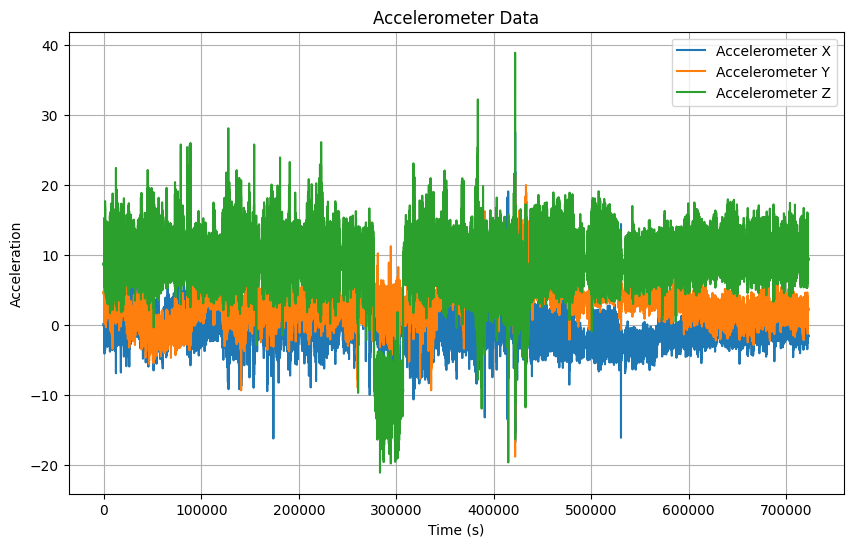

In [3]:
# Generate array of times
time = np.arange(0,722582)
# Plot accelerometer data
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(time, combined_df.iloc[:,0], label='Accelerometer X')
plt.plot(time, combined_df.iloc[:,1], label='Accelerometer Y')
plt.plot(time, combined_df.iloc[:,2], label='Accelerometer Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.title('Accelerometer Data')
plt.legend()
plt.grid(True)
plt.show()

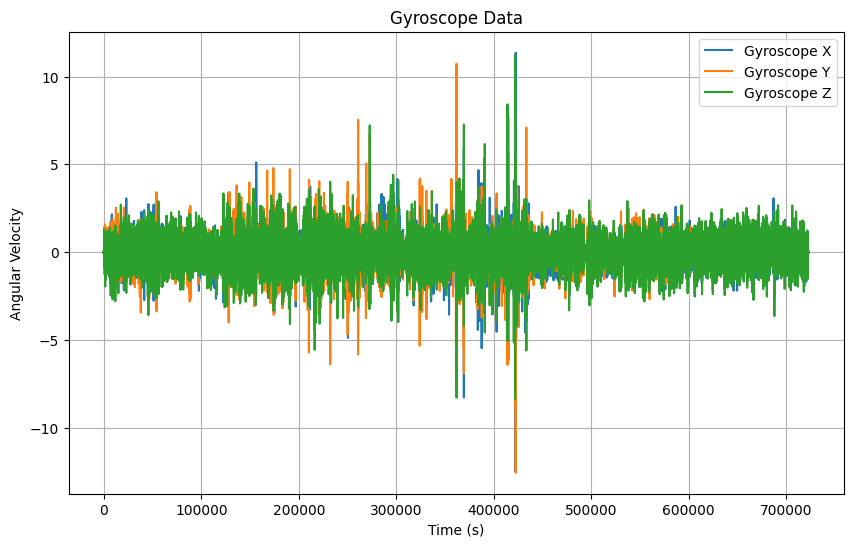

In [4]:
# Plot Gyroscope data
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(time, combined_df.iloc[:,3], label='Gyroscope X')
plt.plot(time, combined_df.iloc[:,4], label='Gyroscope Y')
plt.plot(time, combined_df.iloc[:,5], label='Gyroscope Z')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity')
plt.title('Gyroscope Data')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
class StepDetectionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features
        self.labels = self.data.iloc[:, 6].values  # Extract the labels

        self.label_mapping = {'No Label': 0, 'start': 1, 'end': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.label_mapping[self.labels[index]])

        return features, label


class StepDetectionTestDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        return features

# Create the train, validation, test dataset
dataset = StepDetectionDataset(combined_df)
test_dataset = StepDetectionTestDataset(test_df)
print(test_df.shape)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

(102091, 6)


In [6]:
# Define the LSTM model
class StepDetectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):
        super(StepDetectionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        self.lstm_layers.append(nn.LSTM(input_size, hidden_size, batch_first=True))
        self.dropout_layers.append(nn.Dropout(dropout))

        for _ in range(1, num_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))
            self.dropout_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hiddens = []
        for layer in range(self.num_layers):
            out, _ = self.lstm_layers[layer](x)
            x = self.dropout_layers[layer](out)
            hiddens.append(out[:, -1, :])

        hidden = torch.stack(hiddens, dim=0).sum(dim=0)
        out = self.fc(hidden)

        return out

Input Data:

The input data consists of sequential sensor readings, represented as a tensor of shape (batch_size, sequence_length, input_size).
Here, batch_size refers to the number of data points in a batch, sequence_length is the length of the sequential data, and input_size is the number of input features.
Forward Pass:

During a forward pass, the input data is passed through the LSTM layers and other components of the model.
Let's assume the input tensor is denoted as x.
LSTM Layers:

The input tensor x is sequentially processed by each LSTM layer in the lstm_layers list.
For each layer, the LSTM layer takes x as input and produces two outputs: out and hidden.
The out tensor has a shape of (batch_size, sequence_length, hidden_size) and represents the output of the LSTM layer at each time step.
The hidden tensor contains the hidden state of the LSTM layer, which is not used in this case.
Dropout Layers:

After each LSTM layer, a dropout layer from the dropout_layers list is applied to the output tensor x.
The dropout layer randomly zeros out elements of x with a probability specified by the dropout parameter. This helps prevent overfitting and improves generalization.
Hidden State Aggregation:

To capture the temporal information from all LSTM layers, the last output of each layer in the out tensor is selected.
Specifically, out[:, -1, :] selects the last time step's output from each layer, resulting in a tensor of shape (num_layers, batch_size, hidden_size).
These hidden states represent the learned representations of the input sequence at different levels of abstraction.
Hidden State Combination:

The hidden states from each layer are stacked using torch.stack() along the first dimension.
The resulting tensor has a shape of (num_layers, batch_size, hidden_size) and represents the combined hidden states from all LSTM layers.
Summation:

The hidden states are then summed along the first dimension to combine the information from all layers.
The sum operation collapses the num_layers dimension, resulting in a tensor of shape (batch_size, hidden_size).
This summation allows the model to capture the relevant information from multiple levels of abstraction.
Fully Connected Layer:

The combined hidden state tensor is passed through the fully connected linear layer (self.fc).
The linear layer performs a linear transformation and maps the hidden_size representation to the num_classes.
The output of this layer is a tensor of shape (batch_size, num_classes), representing the predicted logits for each class.
Output:

The output logits are returned as the output of the forward pass.
During training, the model uses the predicted logits and the actual labels to compute the loss and update the model's parameters through backpropagation. The process is repeated for multiple iterations (epochs) to optimize the model's performance.

In the given code snippet, self.lstm_layers.append(nn.LSTM(input_size, hidden_size, batch_first=True)) and self.dropout_layers.append(nn.Dropout(dropout)) are called twice because the code is intended to create multiple layers of LSTM and dropout.

Let's break it down step by step:

The first self.lstm_layers.append(nn.LSTM(input_size, hidden_size, batch_first=True)) line adds an LSTM layer to the self.lstm_layers list. This creates the initial LSTM layer with an input size of input_size and a hidden size of hidden_size. The batch_first=True argument indicates that the input and output tensors of the LSTM layer have the shape (batch_size, sequence_length, hidden_size).

The second self.dropout_layers.append(nn.Dropout(dropout)) line adds a dropout layer to the self.dropout_layers list. This dropout layer is applied after the first LSTM layer, providing regularization by randomly setting a fraction of the input elements to zero during training.

The loop (for _ in range(1, num_layers)) repeats the above two lines num_layers - 1 times, creating additional LSTM and dropout layers.

By calling these lines multiple times within the loop, the code creates a stacked LSTM architecture. Each iteration of the loop adds a new LSTM layer and a corresponding dropout layer to the respective lists. This stacking of layers enables the model to learn more complex patterns and capture long-term dependencies in the input data.

In summary, the purpose of calling self.lstm_layers.append(nn.LSTM(input_size, hidden_size, batch_first=True)) and self.dropout_layers.append(nn.Dropout(dropout)) twice is to add multiple layers of LSTM and dropout to construct a stacked LSTM model.

python
class StepDetectionLSTM(nn.Module):

- This line defines a class called `StepDetectionLSTM` that inherits from `nn.Module`. This class represents the LSTM model for step detection.

python
def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):

- This is the constructor method of the class. It initializes the parameters of the LSTM model.
- `input_size`: The size of the input features for each time step.
- `hidden_size`: The number of features in the hidden state of the LSTM.
- `num_layers`: The number of LSTM layers in the model.
- `num_classes`: The number of output classes for step detection.
- `dropout`: The dropout probability to be applied to the LSTM layers.

python
super(StepDetectionLSTM, self).__init__()

- This line calls the constructor of the parent class (`nn.Module`) to properly initialize the `StepDetectionLSTM` object.

python
self.hidden_size = hidden_size
self.num_layers = num_layers

- These lines assign the values of `hidden_size` and `num_layers` to instance variables of the class for later use.

python
self.lstm_layers = nn.ModuleList()
self.dropout_layers = nn.ModuleList()

- These lines define two `nn.ModuleList` objects to store the LSTM layers and dropout layers.

python
self.lstm_layers.append(nn.LSTM(input_size, hidden_size, batch_first=True))
self.dropout_layers.append(nn.Dropout(dropout))

- These lines add the first LSTM layer and the corresponding dropout layer to the respective `ModuleList` objects.
- The `nn.LSTM` class is used to define an LSTM layer with `input_size` input features, `hidden_size` hidden features, and `batch_first=True` to accept input in the shape `(batch_size, sequence_length, input_size)`.
- The `nn.Dropout` class is used to define a dropout layer with a dropout probability of `dropout`.

python
for _ in range(1, num_layers):
    self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))
    self.dropout_layers.append(nn.Dropout(dropout))

- These lines add additional LSTM layers and corresponding dropout layers to the `ModuleList` objects.
- The loop iterates `num_layers - 1` times, as the first LSTM layer has already been added.
- Each iteration adds an LSTM layer with `hidden_size` input and hidden features, and a dropout layer with a dropout probability of `dropout`.

python
self.fc = nn.Linear(hidden_size, num_classes)

- This line defines a fully connected (linear) layer that maps the final hidden state of the LSTM to the output classes.
- The `nn.Linear` class is used to define a linear transformation with `hidden_size` input features and `num_classes` output features.

python
def forward(self, x):

- This method defines the forward pass of the LSTM model. It takes an input tensor `x` as input and returns the output tensor.

python
hiddens = []
for layer in range(self.num_layers):
    out, _ = self.lstm_layers[layer](x)
    x = self.dropout_layers[layer](out)
    hiddens.append(out[:, -1, :])

- These lines iterate over the LSTM layers and perform the forward pass.
- For each layer, the input `x` is passed through the corresponding LSTM layer. The output `out` and the hidden state are returned by the LSTM layer.
- The output `out` is then passed through the corresponding dropout layer and reassigned to `x` for the next layer.
- The last hidden state of each layer (`out[:, -1, :]`) is appended to the `hiddens` list.

python
hidden = torch.stack(hiddens, dim=0).sum(dim=0)
out = self.fc(hidden)

- These lines stack the hidden states from all layers along the first dimension, sum them, and assign the result to `hidden`.
- The `hidden` tensor is then passed through the fully connected layer (`self.fc`) to obtain the final output `out`.

python
return out

- This line returns the output tensor `out` as the result of the forward pass.

When batch_first is set to True, it means that the input tensor is expected to have its batch size as the first dimension. For example, if you have a batch of input sequences with a shape of (batch_size, sequence_length, input_size), setting batch_first=True would rearrange the tensor to have the shape (batch_size, sequence_length, input_size).

The reason why batch_first is set to True in some cases is to provide a more intuitive and convenient format for handling batched data. It allows you to directly access and manipulate the sequences within the batch without having to transpose the tensor.

Setting batch_first=True can make the code more readable and align with how we typically think about batched data in machine learning tasks. However, it's important to note that not all frameworks or models require the batch_first parameter, and some may assume the default format of (sequence_length, batch_size, input_size).

In [7]:
# Define the hyperparameters
input_size = 6
num_classes = 3
batch_size = 64
num_epochs = 5
learning_rate = 0.001
num_layers = 6
hidden_size = 256
dropout = 0.5

In [8]:
# Initialize the LSTM model
model = StepDetectionLSTM(input_size, hidden_size, num_layers, num_classes, dropout=dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Function to calculate the accuracy of the model
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
# Training loop
# Initialize empty lists to store loss values
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(features.unsqueeze(1))
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_losses.append(val_loss)

    # Print training and validation results for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.1624, Train Accuracy: 0.9644, Val Loss: 0.1571, Val Accuracy: 0.9645
Epoch 2/10, Train Loss: 0.1547, Train Accuracy: 0.9644, Val Loss: 0.1535, Val Accuracy: 0.9645
Epoch 3/10, Train Loss: 0.1524, Train Accuracy: 0.9644, Val Loss: 0.1527, Val Accuracy: 0.9645
Epoch 4/10, Train Loss: 0.1510, Train Accuracy: 0.9644, Val Loss: 0.1498, Val Accuracy: 0.9645
Epoch 5/10, Train Loss: 0.1503, Train Accuracy: 0.9644, Val Loss: 0.1525, Val Accuracy: 0.9645
Epoch 6/10, Train Loss: 0.1498, Train Accuracy: 0.9644, Val Loss: 0.1496, Val Accuracy: 0.9645
Epoch 7/10, Train Loss: 0.1495, Train Accuracy: 0.9644, Val Loss: 0.1487, Val Accuracy: 0.9645
Epoch 8/10, Train Loss: 0.1491, Train Accuracy: 0.9644, Val Loss: 0.1495, Val Accuracy: 0.9645
Epoch 9/10, Train Loss: 0.1490, Train Accuracy: 0.9644, Val Loss: 0.1486, Val Accuracy: 0.9645
Epoch 10/10, Train Loss: 0.1488, Train Accuracy: 0.9644, Val Loss: 0.1486, Val Accuracy: 0.9645


In [19]:
# Test the model
model.eval()
predictions = []

with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = model(features.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Convert predictions to labels
labels_mapping = {v: k for k, v in dataset.label_mapping.items()}
predicted_labels = [labels_mapping[prediction] for prediction in predictions]

python
model.eval()

- This line sets the model to evaluation mode. This is important because it disables certain layers or operations, such as dropout, that are only used during training. In evaluation mode, the model will produce deterministic outputs.

python
predictions = []

- This line initializes an empty list called `predictions` to store the predicted class labels.

python
with torch.no_grad():

- This line starts a context block where gradients are not calculated. It is used in combination with `torch.no_grad()` to disable gradient calculation during inference, which saves memory and speeds up computation.

python
for features in test_loader:

- This line starts a loop that iterates over the `test_loader`. The `test_loader` is an iterable that provides batches of test features.

python
features = features.to(device)

- This line moves the test features to the device (e.g., GPU) specified during model training. It ensures that the data is in the correct format and on the correct device for inference.

python
outputs = model(features.unsqueeze(1))

- This line passes the test features through the model to obtain the outputs. The `unsqueeze(1)` function is used to add a dimension to the features tensor to match the expected input shape of the model.

python
_, predicted = torch.max(outputs, 1)

- This line uses the `torch.max()` function to get the predicted class index for each input in the batch. The `1` argument specifies that the maximum value is taken along the second dimension, which represents the classes.

python
predictions.extend(predicted.cpu().numpy())

- This line extends the `predictions` list with the predicted class indices. The `cpu().numpy()` functions are used to move the predicted tensor to the CPU and convert it to a NumPy array.

python
labels_mapping = {v: k for k, v in dataset.label_mapping.items()}
predicted_labels = [labels_mapping[prediction] for prediction in predictions]

- These lines convert the predicted class indices to their corresponding labels using a mapping dictionary. The `labels_mapping` dictionary is created based on the `label_mapping` attribute of the `dataset` object. The predicted labels are stored in the `predicted_labels` list.


In [20]:
def test(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs.unsqueeze(1))
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probabilities)

    return predictions

def write_output_file(file_path, predictions):
    with open(file_path, 'w') as file:
        file.write('index,start,end\n')
        for time_point, pred in enumerate(predictions):
            start_prob = pred[1]  # Probability of being the start of a step
            end_prob = pred[2]  # Probability of being the end of a step
            line = f'{time_point},{start_prob:.6f},{end_prob:.6f}\n'
            file.write(line)

python
def test(model, dataloader, device):

- This line defines a function called `test` that takes three parameters: `model`, `dataloader`, and `device`. This function is used to perform testing or inference using the provided model and dataloader.

python
model.eval()

- This line sets the model to evaluation mode before performing inference. This ensures that certain layers or operations that are only used during training, such as dropout, are disabled. In evaluation mode, the model will produce deterministic outputs.

python
predictions = []

- This line initializes an empty list called `predictions` to store the predicted probabilities.

python
with torch.no_grad():

- This line starts a context block where gradients are not calculated. It is used in combination with `torch.no_grad()` to disable gradient calculation during inference, which saves memory and speeds up computation.

python
for inputs in dataloader:

- This line starts a loop that iterates over the `dataloader`. The `dataloader` is an iterable that provides batches of inputs for testing.

python
inputs = inputs.to(device)

- This line moves the inputs to the device (e.g., GPU) specified during model training. It ensures that the data is in the correct format and on the correct device for inference.

python
outputs = model(inputs.unsqueeze(1))

- This line passes the inputs through the model to obtain the outputs. The `unsqueeze(1)` function is used to add a dimension to the inputs tensor to match the expected input shape of the model.

python
probabilities = torch.softmax(outputs, dim=1).cpu().numpy()

- This line applies the softmax function to the outputs to obtain class probabilities. The `dim=1` argument specifies that the softmax function is applied along the second dimension, which represents the classes. The resulting tensor is then moved to the CPU and converted to a NumPy array.

python
predictions.extend(probabilities)

- This line extends the `predictions` list with the predicted probabilities. The `extend()` function is used to add the elements of the `probabilities` array to the end of the `predictions` list.

python
return predictions

- This line returns the `predictions` list, which contains the predicted probabilities for each input in the dataloader.

In [21]:
# Test the model and write predictions to an output file
output_file = '/content/sample_data/step_predictions_LSTM.csv'
test_predictions = test(model, test_loader, device)
write_output_file(output_file, test_predictions)

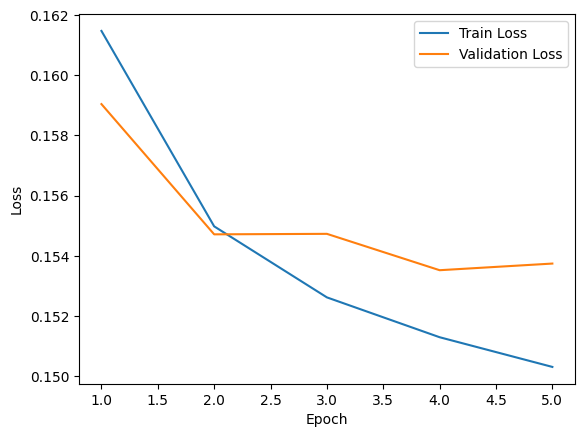

In [22]:
# Plot the graph
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1. LSTM:
   - Strengths: LSTM is well-suited for processing sequential data and capturing dependencies over long sequences. It has a memory mechanism that allows it to retain information from earlier parts of the sequence, making it effective for tasks where order and context are important.
   - Limitations: LSTM can be computationally expensive and may struggle with long sequences due to the sequential nature of its computations. It may also have difficulty capturing global dependencies in the sequence.

2. CNN:
   - Strengths: CNNs are widely used for image and video processing tasks due to their ability to effectively extract local patterns and spatial information through convolutional layers. They can capture spatial hierarchies and are computationally efficient.
   - Limitations: CNNs are primarily designed for grid-like data, such as images, and may not perform as well on sequential data. They typically lack the ability to capture long-term dependencies and temporal patterns in the data.

3. Transformer:
   - Strengths: Transformers have gained popularity for sequence modeling tasks, especially in natural language processing, due to their ability to capture global dependencies using self-attention mechanisms. They can process inputs in parallel, making them more efficient for long sequences compared to sequential models like LSTM. Transformers excel at capturing long-range dependencies and have achieved state-of-the-art performance in various tasks.
   - Limitations: Transformers may require a larger amount of training data compared to LSTM and CNN. They can also be computationally intensive, especially for very large sequences.

In summary, LSTM is suitable for tasks where capturing long-term dependencies and contextual information is crucial. CNNs are effective for grid-like data, such as images, but may not be as effective for sequential data. Transformers are particularly powerful for sequence modeling tasks, especially when dealing with long sequences and capturing global dependencies.


Reasons to Choose LSTM and Transformer:
1. LSTM: LSTM is particularly useful when dealing with sequential data, such as time-series or text data. It can capture long-term dependencies and has a memory mechanism that allows it to retain information over long sequences. This makes it suitable for tasks where the order and context of the data are important.